## Supervised learning (classification)

**Data science problem:** Recognize hand written digits from images.

A real world example would be recognizing hand written zip codes on mails so that they can be sorted according to destiantion. This would help the postal service to greatly reduce the costs associated with mail handling.

Steps of our data science process:

1. [Set the research goal:](#1-research-goal) Let computer to recognize numbers from images
2. [Acquire data:](#2-acquire-data) We will be using MNIST data set which is available in the internet
3. [Prepare data:](#3-prepare-data) Standardize images so that they are all the same size
4. [Build model:](#4-model-selection) Build a classification model
5. [Presentation:](#5-report-and-present-the-results) Report the results

[Resources](Resources)

## 1. Research goal

We want to train a model that can recognize hand written digits from images.

### Quick tutorial on downloading and unzipping files from webpages

__1a. Download using `requests` library__

In [1]:
import requests

url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
    
f.name

'train-labels-idx1-ubyte.gz'

__1b. Unzip using `gzip` library__

In [2]:
import gzip
with gzip.open(filename, 'rb') as f:
    file_content = f.read(16) # read first 16 lines
    print(file_content)

b'\x00\x00\x08\x01\x00\x00\xea`\x05\x00\x04\x01\t\x02\x01\x03'


__2a. Download using shell commands__

In [3]:
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   644k      0 --:--:-- --:--:-- --:--:--  641k


__2b. Unzip using shell command__

In [4]:
!gunzip -c train-labels-idx1-ubyte.gz > train-labels.dat

## 2. Acquire data

Download files. (There are 4 separate files)

In [5]:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz # training set images
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz # training set labels
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz # test set images
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz # test set labels

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  8720k      0  0:00:01  0:00:01 --:--:-- 8728k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   674k      0 --:--:-- --:--:-- --:--:--  687k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  4283k      0 --:--:-- --:--:-- --:--:-- 4282k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0   151k      0 --:--:-- --:--:-- --:--:--  152k


Exract files and rename them.

In [6]:
!gunzip -c train-images-idx3-ubyte.gz > train-images.dat
!gunzip -c train-labels-idx1-ubyte.gz > train-labels.dat
!gunzip -c t10k-images-idx3-ubyte.gz > test-images.dat
!gunzip -c t10k-labels-idx1-ubyte.gz > test-labels.dat

Read binary data into separate lists. Repeat for each dataset.

In [7]:
def load_binary_data(filename):
    data = []
    with open(filename, 'rb') as f:
        file_content = f.read()
        for line in file_content:
            data.append(line)
        return data
    
train_images = load_binary_data('train-images.dat')
train_labels = load_binary_data('train-labels.dat')
test_images = load_binary_data('test-images.dat')
test_labels = load_binary_data('test-labels.dat')

Let's take a look at what the data looks like:

In [8]:
train_images[:20]

[0, 0, 8, 3, 0, 0, 234, 96, 0, 0, 0, 28, 0, 0, 0, 28, 0, 0, 0, 0]

In [9]:
train_labels[:20]

[0, 0, 8, 1, 0, 0, 234, 96, 5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5]

It looks like there is some overhead/header in the begining of the data. Let's figure out how long the overhead is. There must be 60,000 images in training set and 10,000 images in test set. Image resolution is 28x28, so one image is represented by `28*28=784` pixels. Overall, the size of the training data must be `784*60000`, and so on.

In [10]:
print('Checking the size of overhead in images:')
print('Training: ', len(train_images) - 784*60000)
print('Test: ', len(test_images) - 784*10000)
print('')
print('Checking the size of overhead in labels')
print('Training: ', len(train_labels) - 60000)
print('Test: ', len(test_labels) - 10000)

Checking the size of overhead in images:
Training:  16
Test:  16

Checking the size of overhead in labels
Training:  8
Test:  8


Looks like we need to get rid of the first 16 values from images and 8 values from labels.

## 3. Prepare data

Discard leading data (16 from images, 8 from labels)

In [11]:
train_images = train_images[16:]
test_images = test_images[16:]
train_labels = train_labels[8:]
test_labels = test_labels[8:]

Our training and test sets are long arrays (lists), so if we want to plot images, we have to convert it back to its 2D-array form.

In [12]:
import numpy as np

train_images = np.array(train_images).reshape((-1,28,28)) # -1 means no constraint on the size of depth as long as the row and column sizes are 28
test_images = np.array(test_images).reshape((-1,28,28))
print('Training set shape: ', train_images.shape)
print('Test set shape: ', test_images.shape)

Training set shape:  (60000, 28, 28)
Test set shape:  (10000, 28, 28)


Let's see first few images in training set:

In [13]:
%matplotlib inline

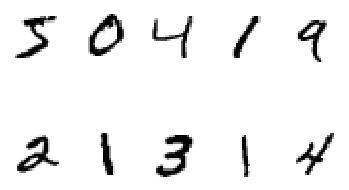

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.axis('off')
    plt.imshow(train_images[i-1], cmap=plt.cm.gray_r, interpolation=None)
plt.show()

An threse are the corresponding labels:

In [15]:
print(train_labels[:10])

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


## 4. Model selection

### a. Initial investigation

The data is ready to use in a model. We are going to go ahead and perform classification on a smaller version of the dataset (6000 samples) just to make sure that we are on the right track.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

# We are going to use a small portion of the dataset for initial investigation
X = train_images[:6000]
y = train_labels[:6000]

# Reshape the images data set so that it has observations in the rows and features in the columns.
n_samples = len(X)
X = X.reshape((n_samples, -1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now, let's perform classification and see the results. We will employ 3 different algorithms.

In [17]:
from sklearn import neighbors, linear_model, naive_bayes

knn = neighbors.KNeighborsClassifier()
nb = naive_bayes.GaussianNB()
logistic = linear_model.LogisticRegression(solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('Naive Bayes score: %f' % nb.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.936364
Naive Bayes score: 0.633838
LogisticRegression score: 0.834848


We achieved a high accuracy using KNN. However, 28x28 pixel resolution is very high with a feaure size of 784. But do we really need all 784 features? Maybe we can do the same if not better using fewer feautures. We can try resizing the image, for example to a 10x10 resolution.

Let's see how we can change the resolution of the digit images.

### b. Dimension reduction

We are going to use the `Scikit-image` module to ___resize___ the images and see what they look like.

#### Quick tutorial on resizing images using Scikit-image

In [18]:
import warnings  
warnings.filterwarnings('ignore')

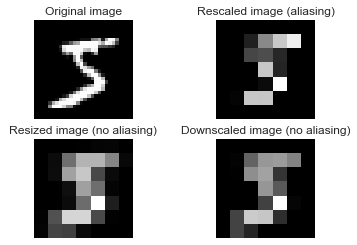

In [19]:
from skimage.transform import rescale, resize, downscale_local_mean

image = train_images[0]

image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (4, 4))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('equal')
ax[0].axis('off')

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")
ax[1].axis('equal')
ax[1].axis('off')

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")
ax[2].axis('equal')
ax[2].axis('off')

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")
ax[3].axis('equal')
ax[3].axis('off')

plt.show()

__It looks like rescaling image with anti-aliasing filter or donwsampling the image might work. Downsampling is easier because it can resize an N-dimensinal numpy array. We will need to play with its parameters to see which one suits best to our needs.__

In [20]:
# Downsample the images and repeat classification
X = train_images[:6000] # Choose a small portion
X = downscale_local_mean(X, (1, 3, 3)) # Downsample at 1/3 (10x10 resolution)
X = X.reshape((n_samples, -1)) # Reshape to 2D array

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Run classification algorithms
print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('Naive Bayes score: %f' % nb.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.950505
Naive Bayes score: 0.605556
LogisticRegression score: 0.901515


In [21]:
print('Original feature size', 28*28)
print('Resized feature size', X[0].shape[0])

Original feature size 784
Resized feature size 100


We achieved an even better accuracy using only 100 features! This is important because we can greatly reduce the computation cost of our classification and maybe try complex algorithms that normally takes a long time to run.

Now the next step is using the entire dataset to build and test our final classification model. We are going to use KNN classifier. First, using our small sample set, let's decide which _k_ value works the best.

0.945959595959596
0.9444444444444444
0.9489898989898989
0.946969696969697
0.9505050505050505
0.9494949494949495
0.9464646464646465
0.9404040404040404
0.9388888888888889
0.9393939393939394
0.9363636363636364
0.9363636363636364
0.9368686868686869
0.9378787878787879
0.9323232323232323
0.9318181818181818
0.9282828282828283
0.9282828282828283
0.9262626262626262
0.9262626262626262


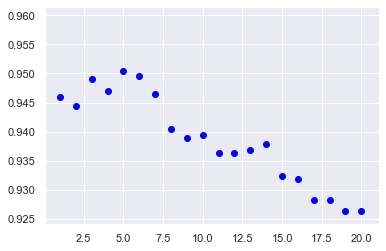

In [22]:
for k in range(1,21):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    acc = knn.fit(X_train, y_train).score(X_test, y_test)
    print(acc)
    plt.scatter(k, acc, c='blue')

We conclude that `k=5` performs slightly better.

### c. Final model

In [23]:
# Resize data
from skimage.transform import downscale_local_mean

X_train = downscale_local_mean(train_images, (1, 3, 3)) # Downsample at 1/3 (10x10 resolution)
X_test = downscale_local_mean(test_images, (1, 3, 3)) # Downsample at 1/3 (10x10 resolution)

In [24]:
# Reshape data
X_train = X_train.reshape((len(X_train), -1))
y_train = train_labels
X_test = X_test.reshape((len(X_test), -1))
y_test = test_labels

In [25]:
# Classify
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=5) # build model
knn.fit(X_train, y_train) # fit training set
predicted = knn.predict(X_test) # predict test set

## 5. Report and present the results:

In [26]:
print('Test accuracy: ', accuracy_score(y_test, predicted))

Test accuracy:  0.9676


In [27]:
print(confusion_matrix(y_test, predicted))

[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1128    3    1    0    0    1    1    1    0]
 [   8    2  997    4    0    0    2   14    5    0]
 [   1    5    7  965    1   12    0    5   12    2]
 [   1    3    3    0  939    0    2    1    1   32]
 [   4    2    0   14    2  855    6    2    4    3]
 [   5    4    0    0    2    2  944    0    1    0]
 [   0   20    7    0    2    0    0  985    1   13]
 [   3    2    4    9    8    6    4    5  926    7]
 [   2    9    3    6   12    3    2    4    4  964]]


In [28]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.97      0.96      0.97       892
           6       0.98      0.99      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Visual representation of actual numbers and predictions:

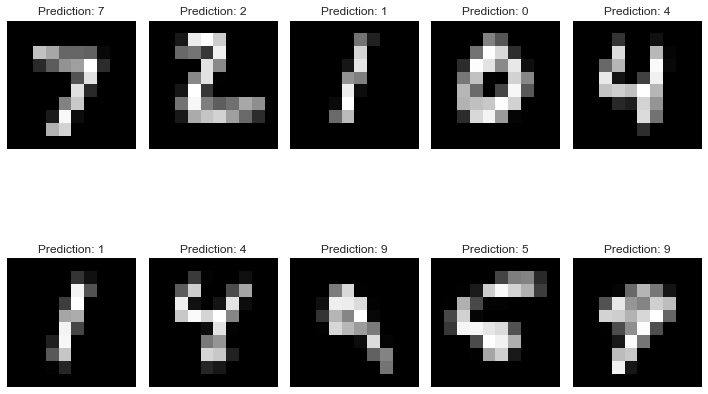

In [29]:
fig=plt.figure(figsize=(10, 8))

for i, (image, prediction) in enumerate(zip(X_test.reshape((-1,10,10))[:10], predicted[:10])):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(image, cmap='Greys_r', interpolation='nearest')
    plt.title('Prediction: %i' % prediction)
plt.tight_layout()
plt.show()

## Resources

* D. Cielen, A. Meysman, M. Ali, Introducing Data Science: Big Data Machine Learning and more using Python tools, Manning Publications.
* Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
* Y. LeCun, C. Cortes, and C.J.C Burges. The MNIST Database. http://yann.lecun.com/exdb/mnist/ accessed on 2019.